# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

*Notebook generated with AI assistance. Please use caution and verify findings.*

Welcome! This notebook introduces [Dandiset 001174, version 0.250331.2218](https://dandiarchive.org/dandiset/001174/0.250331.2218), a data collection featuring one-photon calcium imaging recorded from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques (Macaca mulatta). The imaging was conducted during rest and arm-reaching tasks.

**What does this notebook cover?**
- An overview of Dandiset 001174 and its metadata
- How to programmatically explore assets in the Dandiset using the DANDI API
- How to stream and access imaging data from a remote NWB file using `remfile`, `h5py`, and `pynwb`
- Basic exploration and visualization of:
  - Raw fluorescence imaging data (first frame)
  - Segmented ROIs (cell masks)
  - Extracted fluorescence traces for individual cells

**Required Packages:**  
- `dandi`  
- `remfile`  
- `h5py`  
- `pynwb`  
- `matplotlib`  
- `pandas`  
- `numpy`

**Note:** No package installation is included; it is assumed you have the packages installed.

Let's get started!

## 1. Dandiset Overview

- **DOI:** [10.48324/dandi.001174/0.250331.2218](https://doi.org/10.48324/dandi.001174/0.250331.2218)
- **Title:** Calcium imaging in SMA and M1 of macaques
- **Species:** Macaca mulatta (Rhesus monkey)
- **Data Type:** One-photon calcium imaging, NWB format
- **Description:** Imaging was performed in deep layers of motor cortices while animals were at rest or engaged in an arm-reaching task. Data contains raw imaging movies, spatial masks for cell segmentation (ROIs), and extracted fluorescence signals per cell.

Associated resources and protocols can be found [here](https://dandiarchive.org/dandiset/001174/0.250331.2218).

## 2. Import Packages and Set Up DANDI API Client

We'll use the DANDI API to list available files ("assets") and obtain streaming links.

In [1]:
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 3. List Assets in the Dandiset

Here, we list files for a particular subject/session. The filenames encode subject IDs and session timestamps.

In [2]:
# Initialize the DANDI API client and fetch the dandiset
dandiset_id = "001174"
version = "0.250331.2218"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, version)
    # List all files in the dandiset for illustration
    asset_list = list(dandiset.get_assets())
    print(f"Total files in Dandiset {dandiset_id} (v{version}):", len(asset_list))
    # Show the first 5 assets
    for asset in asset_list[:5]:
        print("-", asset.path)

Total files in Dandiset 001174 (v0.250331.2218): 45
- sub-V/sub-V_ses-20230309T110929_ophys.nwb
- sub-Q/sub-Q_ophys.nwb
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb


## 4. Select an Example NWB File and Prepare for Streaming Access

Let's pick a session: `sub-V/sub-V_ses-20230309T110929_ophys.nwb`, corresponding to imaging in M1 during an arm-reaching task (subject V, male, age ~4 years).

In [3]:
# Select one asset (file) for analysis
selected_filename = "sub-V/sub-V_ses-20230309T110929_ophys.nwb"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, version)
    asset = next(dandiset.get_assets_by_glob(selected_filename))
    url = asset.download_url

print("Remote NWB file download URL:", url)

Remote NWB file download URL: https://api.dandiarchive.org/api/dandisets/001174/versions/0.250331.2218/assets/a2b04c7f-f671-4a55-ac36-5df4d842dfc2/download/


## 5. Stream NWB Data and Open with pynwb

We'll use `remfile` + `h5py` to stream the file, and open it with `pynwb.NWBHDF5IO` for reading.

In [4]:
# Stream the NWB file remotely (do not download entire file)
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()
print("Loaded NWB file:", nwb)

Loaded NWB file: root pynwb.file.NWBFile at 0x134958044697504
Fields:
  acquisition: {
    OnePhotonSeries <class 'pynwb.ophys.OnePhotonSeries'>
  }
  devices: {
    Miniscope <class 'pynwb.device.Device'>
  }
  file_create_date: [datetime.datetime(2024, 11, 21, 21, 30, 50, 335652, tzinfo=tzutc())]
  identifier: ef45b76c-6097-4571-bfef-7f9cc2e9c3bb
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: Calcium imaging in M1 during the arm reaching condition
  session_start_time: 2023-03-09 11:09:29.585000+00:00
  subject: subject pynwb.file.Subject at 0x134958042669440
Fields:
  age: P4Y
  age__reference: birth
  sex: M
  species: Macaca mulatta
  subject_id: V

  timestamps_reference_time: 2023-03-09 11:09:29.585000+00:00



## 6. Basic NWB File Metadata

Let's display some information about the session, subject, and imaging settings.

In [5]:
print("Session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("Subject ID:", nwb.subject.subject_id)
print("Subject age:", nwb.subject.age)
print("Subject sex:", nwb.subject.sex)
print("Species:", nwb.subject.species)

Session description: Calcium imaging in M1 during the arm reaching condition
Session start time: 2023-03-09 11:09:29.585000+00:00
Subject ID: V
Subject age: P4Y
Subject sex: M
Species: Macaca mulatta


## 7. Explore Imaging Data: OnePhotonSeries

The main imaging movie is stored in `acquisition['OnePhotonSeries']`.
- Shape: `(time, height, width)`  
- For this file: (5185, 1280, 800)

We'll plot the first frame to visualize the raw calcium imaging data.

Imaging movie shape (frames, h, w): (5185, 1280, 800)


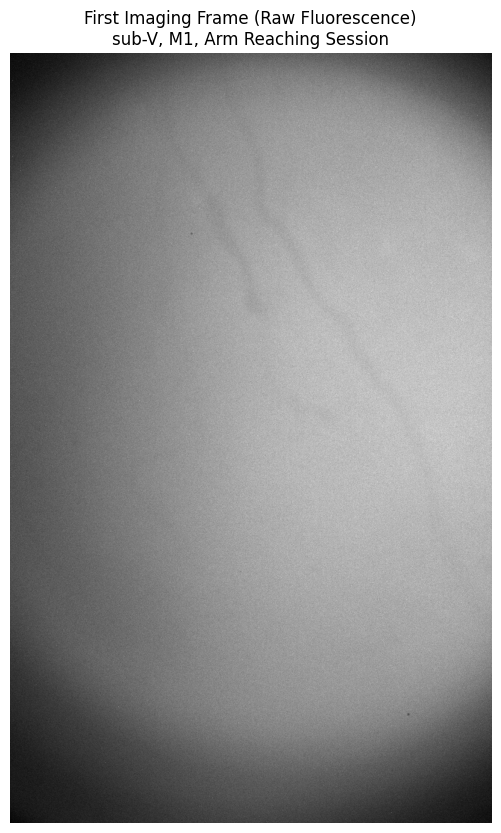

In [6]:
# Access the OnePhotonSeries object
one_photon = nwb.acquisition["OnePhotonSeries"]
img_shape = one_photon.data.shape
print("Imaging movie shape (frames, h, w):", img_shape)

# Fetch and plot the first imaging frame
first_frame = one_photon.data[0, :, :]  # shape (1280, 800)

plt.figure(figsize=(8, 10))
plt.imshow(first_frame, cmap="gray")
plt.title("First Imaging Frame (Raw Fluorescence)\nsub-V, M1, Arm Reaching Session")
plt.axis("off")
plt.show()

## 8. Cell Segmentation Masks (ROIs)

Segmented cell masks (ROIs) are stored in the `processing['ophys']` module in the `ImageSegmentation > PlaneSegmentation`.
- Each ROI corresponds to an individual cell.
- Let's display all cell masks overlayed on the first imaging frame.

Number of segmented cell ROIs: 11


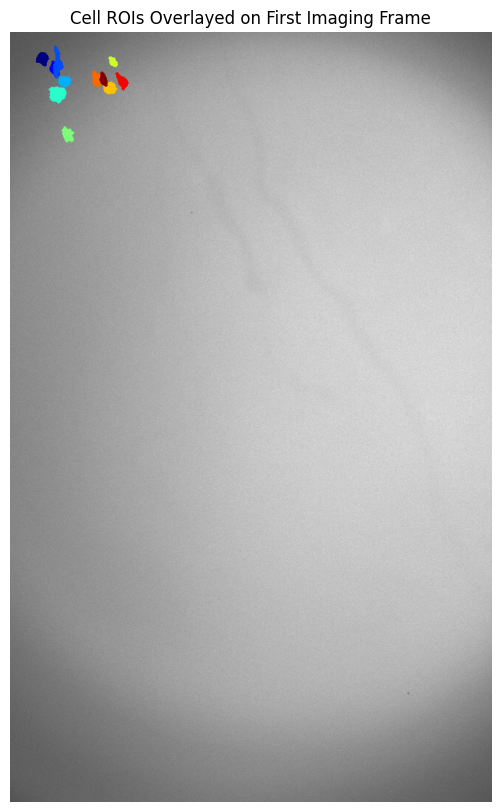

In [7]:
# Access PlaneSegmentation for masks
plane_seg = nwb.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations["PlaneSegmentation"]
num_rois = len(plane_seg)
print(f"Number of segmented cell ROIs: {num_rois}")

# Each mask is a boolean numpy array, same shape as imaging frame
overlay = np.zeros(first_frame.shape, dtype=np.float32)
colors = plt.cm.jet(np.linspace(0, 1, num_rois))

plt.figure(figsize=(8, 10))
plt.imshow(first_frame, cmap="gray", alpha=0.7)
for idx in range(num_rois):
    mask = plane_seg.image_mask[idx]
    # Outline mask
    contour = np.where(mask > 0)
    plt.scatter(contour[1], contour[0], color=colors[idx], s=0.1, label=f"Cell {idx+1}" if idx<1 else None)

plt.title("Cell ROIs Overlayed on First Imaging Frame")
plt.axis("off")
plt.show()

## 9. Extracted Fluorescence Traces for Each Cell

Fluorescence traces for each cell over time are found in `processing['ophys'].data_interfaces['Fluorescence']['RoiResponseSeries']`.
Let's plot these for all cells in this session.

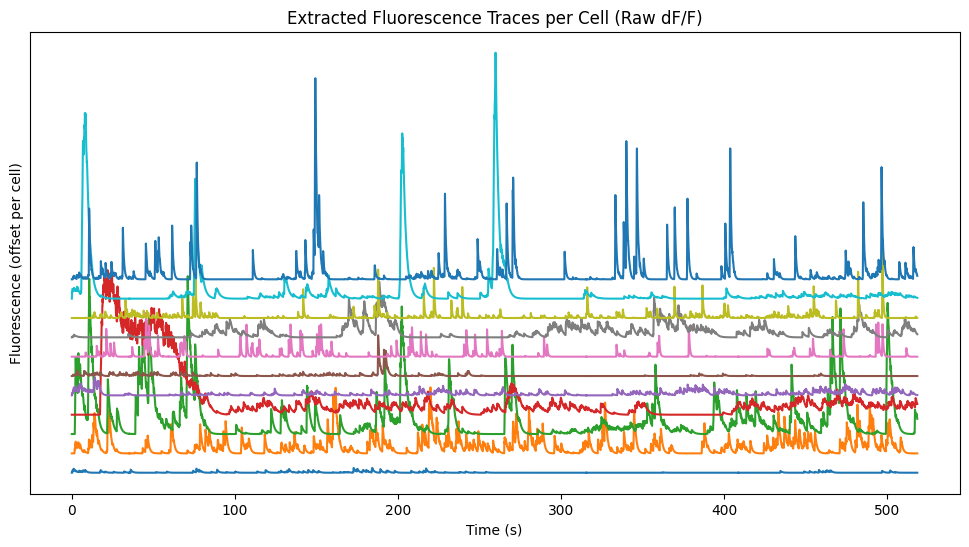

In [8]:
# Access ROI fluorescence traces (dF/F)
roi_response = nwb.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series["RoiResponseSeries"]
traces = roi_response.data[:]  # shape (5185, 11)
time = np.arange(traces.shape[0]) / roi_response.rate  # seconds

plt.figure(figsize=(12, 6))
offset = 5  # Vertical offset for clarity
for i in range(traces.shape[1]):
    plt.plot(time, traces[:, i] + i*offset, label=f'Cell {i+1}')
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence (offset per cell)")
plt.title("Extracted Fluorescence Traces per Cell (Raw dF/F)")
plt.yticks([])
plt.show()

## 10. Amplitude of Detected Neural Events

Optionally, inspect the amplitude of detected events in each cell (from `EventAmplitude`). This can help highlight detected calcium transients (e.g., putative spikes or bursts).

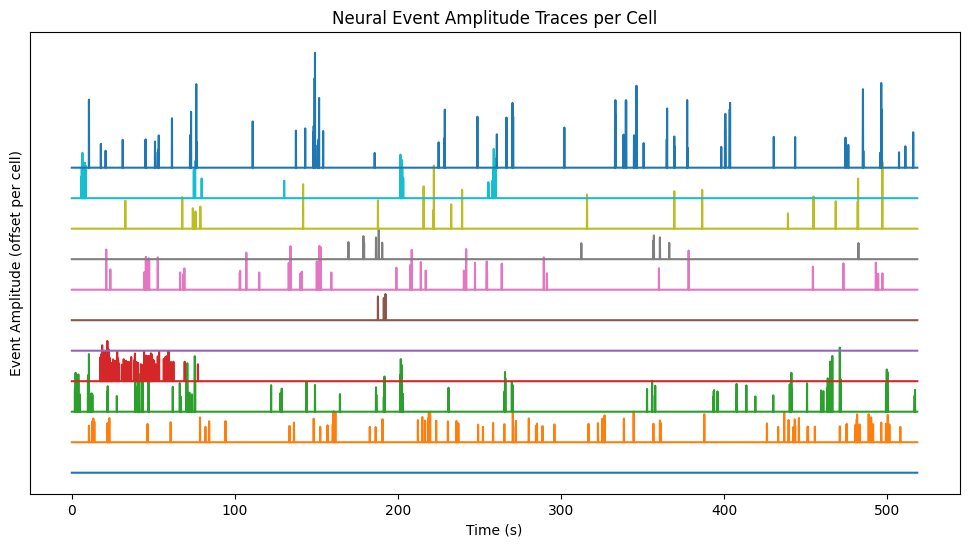

In [9]:
event_amp = nwb.processing["ophys"].data_interfaces["EventAmplitude"]
event_traces = event_amp.data[:]  # shape (5185, 11)

plt.figure(figsize=(12, 6))
for i in range(event_traces.shape[1]):
    plt.plot(time, event_traces[:, i] + i*offset, label=f'Cell {i+1}')
plt.xlabel("Time (s)")
plt.ylabel("Event Amplitude (offset per cell)")
plt.title("Neural Event Amplitude Traces per Cell")
plt.yticks([])
plt.show()

## 11. Summary and Next Steps

You've now loaded a remote NWB calcium imaging dataset, visualized cell masks, and plotted fluorescence traces for all segmented cells in a session from Dandiset 001174!

**To explore further, you might:**
- Repeat these steps on other sessions or subjects
- Analyze co-activation or correlations between cells
- Relate neural activity to behavioral events (if available in metadata)

For more details about this Dandiset, see the [official DANDI Archive page](https://dandiarchive.org/dandiset/001174/0.250331.2218) and associated publications.

---

*Remember: This notebook was produced with AI assistance. Please verify code, visualizations, and scientific interpretations for your use case.*